<a href="https://colab.research.google.com/github/luancordeiro/lidarpy/blob/main/klett_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

!git clone https://github.com/luancordeiro/lidarpy.git
os.chdir("lidarpy")

Cloning into 'lidarpy'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 362 (delta 94), reused 104 (delta 51), pack-reused 205
Receiving objects: 100% (362/362), 68.02 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (238/238), done.


# Importing the data

In [3]:
from lidarpy import GetData

directory = "/content/lidarpy/lidarpy/tests/data/binary"
files = [file for file in os.listdir(directory) if file.startswith("RM")]
files.sort()

data = GetData(directory, files)
lidar_data = data.get_xarray()

# Removing the background noise and grouping the bins

In [4]:
from lidarpy.data.manipulation import remove_background, groupby_nbins

nbins = 5

lidar_clean = (lidar_data
               .pipe(remove_background, [25_000, 80_000])
               .pipe(groupby_nbins, nbins))

In [5]:
da_klett = lidar_clean.mean("time")[[1], 1100 // nbins:2100 // nbins]
z_klett = da_klett.coords["altitude"]

# Getting the atmospheric data

In [6]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

df_sonde = pd.read_csv("lidarpy/tests/data/sonde_data.txt")

f_temp = interp1d(df_sonde["alt"].to_numpy(), df_sonde["temp"].to_numpy())
f_pres = interp1d(df_sonde["alt"].to_numpy(), df_sonde["pres"].to_numpy())

temperature = f_temp(z_klett)
pressure = f_pres(z_klett)

# Klett inversion

In [7]:
from lidarpy.inversion.klett import Klett

klett = Klett(da_klett, 
              [9000, 11000],
              355,
              19,
              pressure,
              temperature
              )

In [8]:
alpha, beta, lr = klett.fit()

mean signal: 1.024315805486715
mean_model: 2.8992307903167494e-16
ab: [ 1.14176643 -0.14176643]


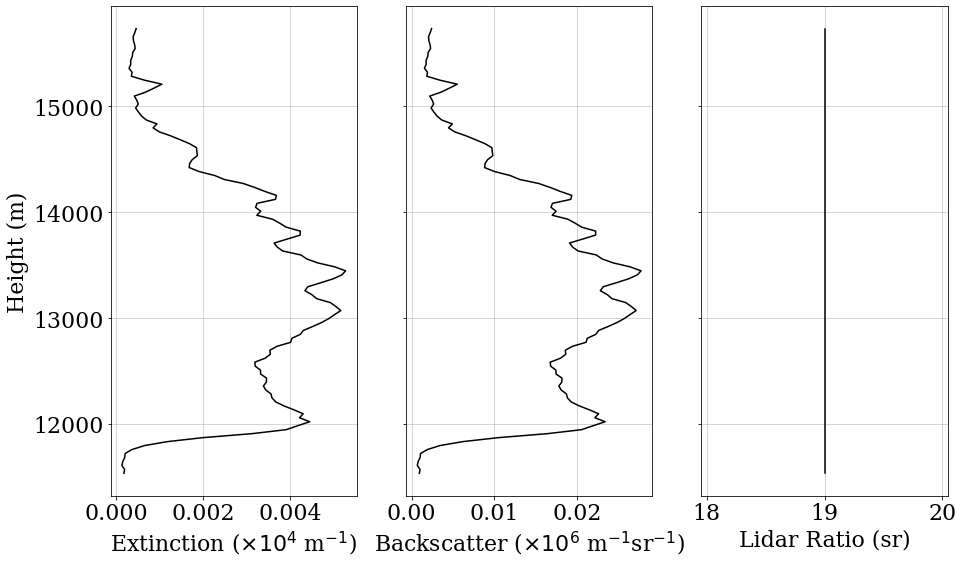

In [9]:
from lidarpy.plot.plotter import plot_3graph_std

ind = (z_klett >= 11500)

plot_3graph_std(z_klett[ind], 
                alpha[ind], 
                beta[ind], 
                lr * np.ones(z_klett.shape)[ind])